In [1]:
import csv
from lib.constants import HARMONIC_FLAGS_LABEL, Harmonic, Kalman
from lib.utils.visualization.constant import PlotType
from lib.utils.visualization.plot_generator import generate_plots
from lib.paths import (
    build_end_of_year_kalman_state_path,
    build_harmonic_trend_path,
    build_kalman_analysis_path,
    build_kalman_result_path,
)
from pprint import pprint
from lib.utils.harmonic import extract_coefficients_from_array, calculate_harmonic_fit
import pandas as pd
from lib.constants import FRACTION_OF_YEAR_LABEL, DATE_LABEL
import os
import shutil

run_directory = (
   "./tests/kalman/Randonia_L7_L8_L9_swir_2017-2019_posthoc/11-26_00:29_slope_unimodal"
)

harmonic_flags = {
    Harmonic.INTERCEPT.value: True,
    Harmonic.SLOPE.value: True,
    Harmonic.UNIMODAL.value: True,
    # Harmonic.BIMODAL.value: True,
    # Harmonic.TRIMODAL.value: False,
}

point = 0

data = build_kalman_result_path(run_directory, point)
harmonic_trend = build_harmonic_trend_path(run_directory, point)
eoy_state = build_end_of_year_kalman_state_path(run_directory, point)

analysis_directory = build_kalman_analysis_path(run_directory, point)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [2]:
import numpy as np

from lib.constants import RETROFITTED_TREND_LABEL


def get_end_of_year_coefficients(eoy_state):
    coef_dic = dict()

    with open(eoy_state, "r") as file:
        reader = csv.reader(file)

        next(reader)

        for line in reader:
            values = line[1:]

            # remove the covariance values
            coefs = values[: len(values) // 2]

            coef_dic[line[0]] = coefs

    return coef_dic

def get_retrofitted_trend(eoy_state_coefs, frac_of_year, harmonic_flags):
    eoy_coefs_by_year = []

    print(list(frac_of_year))

    for frac_year in list(frac_of_year):
        year = int(frac_year)
        coefs_array = eoy_state_coefs.get(str(year), [])

        coefs = extract_coefficients_from_array(coefs_array, harmonic_flags)

        eoy_coefs_by_year.append((frac_year, coefs))

    estimates = [
        [
            frac_year,
            calculate_harmonic_fit(coefs, frac_year),
        ]
        for frac_year, coefs in eoy_coefs_by_year
    ]

    df =  pd.DataFrame(
            estimates, columns=[FRACTION_OF_YEAR_LABEL, RETROFITTED_TREND_LABEL]
        )

    df["year"] = df[FRACTION_OF_YEAR_LABEL].apply(lambda x: int(x))

    print(df[df["year"] == 2017].iloc[-1].tolist())
    print(df[df["year"] == 2018].iloc[-1].tolist())
    print(df[df["year"] == 2019].iloc[-1].tolist())

    print(df)

    return df



# pprint(coefs.get("2018"))
# pprint(coefs)
data = pd.read_csv(data)


coefs = get_end_of_year_coefficients(eoy_state)
print(coefs)

retrofitted_trend = get_retrofitted_trend(coefs, data[FRACTION_OF_YEAR_LABEL], harmonic_flags)


for year, coef in coefs.items():
    data_for_year = data[pd.to_datetime(data[DATE_LABEL]).dt.year == int(year)]

    final_coefs = data_for_year[[Harmonic.INTERCEPT.value, Harmonic.SLOPE.value, Harmonic.COS.value, Harmonic.SIN.value]].iloc[-1].tolist()

    print(float(final_coefs[0]) - float(coef[0]))
    print(float(final_coefs[1]) - float(coef[1]))
    print(float(final_coefs[2]) - float(coef[2]))
    print(float(final_coefs[3]) - float(coef[3]))

    print(np.isclose(float(final_coefs[0]) - float(coef[0]), 0.0, 1e-10))
    print(np.isclose(float(final_coefs[1]) - float(coef[1]), 0.0, 1e-10))
    print(np.isclose(float(final_coefs[2]) - float(coef[2]), 0.0, 1e-10))
    print(np.isclose(float(final_coefs[3]) - float(coef[3]), 0.0, 1e-10))

# retrofitted_trend = get_retrofitted_trend_v2(coefs, data[FRACTION_OF_YEAR_LABEL], harmonic_flags)

# data = data.merge(retrofitted_trend, on=FRACTION_OF_YEAR_LABEL, how="inner")

# filtered_data = data[
#     [ESTIMATE_LABEL, Kalman.RETROFITTED.value, DATE_LABEL, Harmonic.INTERCEPT.value, Harmonic.SLOPE.value, Harmonic.COS.value, Harmonic.SIN.value]
# ]

# filtered_data["residual"] = filtered_data[ESTIMATE_LABEL] - filtered_data[Kalman.RETROFITTED.value]

# filtered_data = filtered_data[
#     (pd.to_datetime(filtered_data[DATE_LABEL]).dt.month == 12)
#     & (pd.to_datetime(filtered_data[DATE_LABEL]).dt.day == 31) 
#     # & (pd.to_datetime(filtered_data[DATE_LABEL]).dt.year == 2018)
# ]

# filtered_data = filtered_data[np.isclose(filtered_data[Harmonic.INTERCEPT.value], 0.032675, 1e-3)]



# print(filtered_data)


{'2017': ['-0.001443774907332107', '0.24684769038388132', '0.06262173339739092', '0.022982273549714077'], '2018': ['0.05187435246409875', '0.2654770315789635', '0.026144295474870842', '0.029190581486473806'], '2019': ['0.04292491363598128', '0.23376112755670372', '-0.0021529454603521105', '0.0190094488193533']}
[2017.0109589041097, 2017.021917808219, 2017.0328767123287, 2017.0438356164384, 2017.054794520548, 2017.0657534246575, 2017.0767123287671, 2017.0876712328768, 2017.0986301369865, 2017.109589041096, 2017.1205479452055, 2017.131506849315, 2017.1424657534249, 2017.1534246575343, 2017.164383561644, 2017.1753424657536, 2017.186301369863, 2017.1972602739727, 2017.208219178082, 2017.219178082192, 2017.2301369863017, 2017.2410958904109, 2017.2520547945203, 2017.2630136986304, 2017.27397260274, 2017.2849315068493, 2017.295890410959, 2017.3068493150688, 2017.317808219178, 2017.3287671232877, 2017.339726027397, 2017.3506849315067, 2017.3616438356164, 2017.372602739726, 2017.3835616438355, 

here


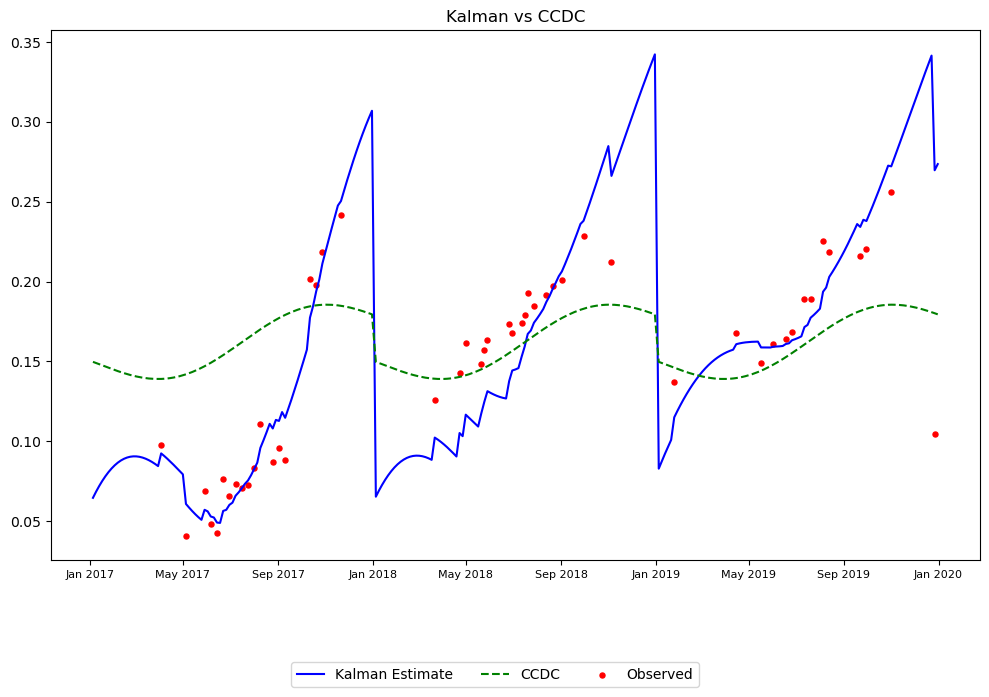

In [3]:
from lib.constants import FORWARD_TREND_LABEL, HARMONIC_TREND_LABEL, RETROFITTED_TREND_LABEL


points = 1

for i in range(0, points):
    data = build_kalman_result_path(run_directory, i)
    harmonic_trend = build_harmonic_trend_path(run_directory, i)
    eoy_state = build_end_of_year_kalman_state_path(run_directory, i)

    analysis_directory = build_kalman_analysis_path(run_directory, i)

    harmonic_flags = {
        Harmonic.INTERCEPT.value: True,
        Harmonic.SLOPE.value: True,
        Harmonic.UNIMODAL.value: True,
        # Harmonic.BIMODAL.value: True,
        # Harmonic.TRIMODAL.value: False,
    }

    PLOT_OPTIONS = {
        # PlotType.KALMAN_VS_HARMONIC: {
        #     "harmonic_trend": harmonic_trend,
        #     "harmonic_flags": harmonic_flags,
        # },
        # PlotType.KALMAN_RETROFITTED: {
        #     HARMONIC_FLAGS_LABEL: harmonic_flags,
        #     Kalman.EOY_STATE.value: eoy_state,
        #     FORWARD_TREND_LABEL: True,
        #     HARMONIC_TREND_LABEL: harmonic_trend,
        # },
        PlotType.KALMAN_VS_CCDC: {
            "title": "Kalman vs CCDC",
        },
        # PlotType.KALMAN_VS_CCDC_COEFS: {
        #     "title": "Kalman vs CCDC Coefficients",
        #     HARMONIC_FLAGS_LABEL: harmonic_flags,
        #     Kalman.EOY_STATE.value: eoy_state,
        # },
    }

    if os.path.exists(analysis_directory):
        shutil.rmtree(analysis_directory)

    generate_plots(data, analysis_directory, PLOT_OPTIONS, display=True)
    # generate_plots(data, analysis_directory, PLOT_OPTIONS, display=False)